<a href="https://colab.research.google.com/github/LuckyLuke147/age_recognition/blob/master/Zdj%C4%99cia_RTG_d%C5%82oni_%7C_Sieci_konwolucyjne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import bibliotek**

In [ ]:
!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from numpy import expand_dims

from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
PATH = '/content/drive/MyDrive/Praca_mgr./dataset/'
SIZE = (224, 224) # EfficientNet

## **Sekcja 2**

In [ ]:
class CustomImageDataGenerator(tf.keras.utils.Sequence):
  def __init__(
      self,
      batch_size: int = 32,
      target_shape: tuple = SIZE,
      img_path: str = None,
      csv_file: str = None,
      **kwargs
  ):

    self.batch_size = batch_size
    self.target_shape = target_shape
    self.img_path = img_path

    if img_path is not None:
      self.indexes = np.array([[Index, Data] for Index, Data in enumerate(
          sorted(os.listdir(self.img_path),
                 key=lambda x: int(x[:-4])))])

    if csv_file is not None:
      self.csv_file = pd.read_csv(csv_file)

    self.augmentation = ImageDataGenerator(height_shift_range=0.5, 
                                           horizontal_flip=True, 
                                           width_shift_range=[-200,200],
                                           rotation_range=90,
                                           brightness_range=[0.2,1.0],
                                           zoom_range=[0.5,1.0],
                                           preprocessing_function=preprocess_input)
    
  def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.indexes) / self.batch_size))

  def __get_age(self, image):
    for img_name, age in self.csv_file[['id', 'boneage']].values:
      if img_name == int(image[:-4]):
        return age

  def __get_gender(self, image):
    for img_name, male in self.csv_file[['id', 'male']].values:
      if img_name == int(image[:-4]):
        return 1 if male is True else 0


  def __getitem__(self, index):
    images = []
    genders = []
    ages = []

    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    
    for i in indexes:

      image_name = i[1]
      age = self.__get_age(image_name)/250
      gender = self.__get_gender(image_name)

      image_directory = self.img_path + image_name

      image = load_img(
          image_directory, 
          color_mode='rgb', 
          target_size=self.target_shape,
          interpolation='nearest')
      
      image_array = img_to_array(image)

      # expand dimension to one sample
      samples = expand_dims(image_array, 0)
      
      # create image data augmentation generator
      datagen = self.augmentation

      # prepare iterator
      it = datagen.flow(samples, batch_size=self.batch_size)
      batch = it.next()
      
      # convert to unsigned integers for viewing
      image = batch[0].astype('uint8')

      images.append(image)
      genders.append(gender)
      ages.append(age)

    return [np.array(images), np.array(genders)], np.array(ages)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_ds = CustomImageDataGenerator(
    img_path = PATH + 'boneage-training-dataset/',
    csv_file = PATH + 'boneage-training-dataset.csv',
    batch_size=10
)
val_ds = CustomImageDataGenerator(
    img_path = PATH + 'boneage-training-dataset/',
    csv_file = PATH + 'boneage-training-dataset.csv',
   batch_size=10
)

# val_ds = CustomImageDataGenerator(
#     img_path = PATH + 'boneage-val-dataset/',
#     csv_file = PATH + 'boneage-val-dataset.csv'
# )

# Tests

In [ ]:

example = sampleObject.next(0)

fetched_image = example[0][0]
fetched_genders = example[0][1]
fetched_ages = example[1]

print(example)

print(fetched_image)
print(fetched_genders)
print(fetched_ages)

print(fetched_image.shape)
print(fetched_genders.shape)
print(fetched_ages.shape)

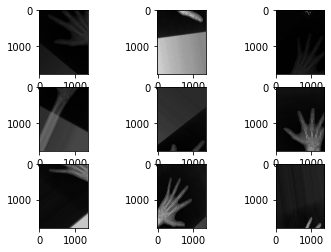

In [ ]:
# EXAMPLE 
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

image_path = PATH + 'boneage-training-dataset/15610.png'

img = load_img(image_path)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.5, 
                             horizontal_flip=True, 
                             width_shift_range=[-200,200],
                             rotation_range=90,
                             brightness_range=[0.2,1.0],
                             zoom_range=[0.5,1.0])
# prepare iterator
it = datagen.flow(samples, batch_size=32)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0].astype('uint8')
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

# Modelowanie

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(*SIZE, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [ ]:
base_model.trainable = False

In [ ]:
# zdjecie
inputs_A = tf.keras.Input(shape=(*SIZE, 3))
# plec
inputs_B = tf.keras.Input(shape=(1,))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs_A, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Concatenate()([x, inputs_B])
# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model([inputs_A, inputs_B], outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb0 (Functional)    (None, 7, 7, 1280)   4049571     ['input_2[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['efficientnetb0[0][0]']         
 alAveragePooling2D)                                                                              
                                                                                              

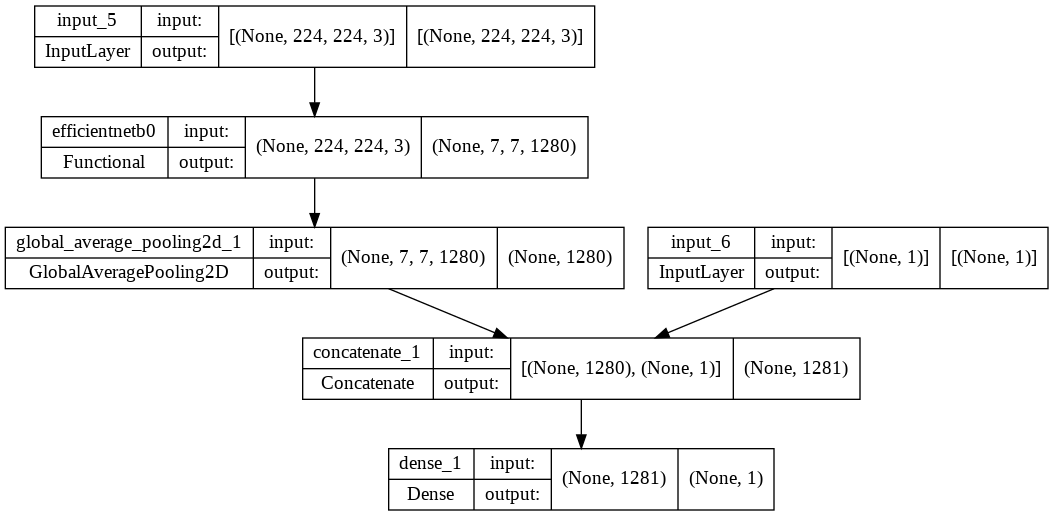

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# kompilowanie modelu
model.compile(optimizer='adam', loss="mse", metrics=[tf.keras.metrics.mean_absolute_error])

# wybrac losowo 10% danych do walidacji. Zrobić osobne foldery train i val i osobne pliki csv.

In [ ]:
# docelowo
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
# history = model.fit(train_ds, validation_data=val_ds, steps_per_epoch=10, epochs=100, validation_steps=5, callbacks=[callback])
history = model.fit(train_ds, steps_per_epoch=10, epochs=100, callbacks=[callback])
# docelowo
# history = model.fit(train_ds, validation_data=val_ds,  epochs=100, callbacks=[callback])

Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 0.0275 - mean_absolute_error: 0.1358
Epoch 2/100
10/10 [==============================] - 10s 1s/step - loss: 0.0322 - mean_absolute_error: 0.1422
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.0327 - mean_absolute_error: 0.1461
Epoch 4/100
10/10 [==============================] - 14s 1s/step - loss: 0.0230 - mean_absolute_error: 0.1235
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 0.0306 - mean_absolute_error: 0.1480
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 0.0339 - mean_absolute_error: 0.1578
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.0339 - mean_absolute_error: 0.1456


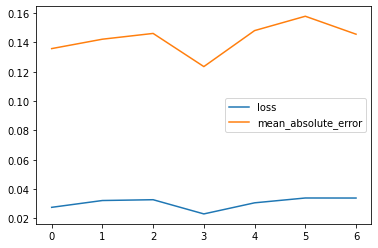

In [ ]:

pd.DataFrame(history.history).plot()